In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, KFold, StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict

import torchvision.utils as vutils
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root="data/train", transform=transform)
# val_dataset = datasets.ImageFolder(root="data/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [3]:
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 9510
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

Распределение классов (правильный порядок):
Класс 0 (0): 110 изображений
Класс 1 (1): 109 изображений
Класс 12 (2): 143 изображений
Класс 23 (3): 119 изображений
Класс 34 (4): 136 изображений
Класс 45 (5): 45 изображений
Класс 56 (6): 123 изображений
Класс 67 (7): 137 изображений
Класс 78 (8): 45 изображений
Класс 89 (9): 49 изображений
Класс 2 (10): 134 изображений
Класс 3 (11): 72 изображений
Класс 4 (12): 117 изображений
Класс 5 (13): 109 изображений
Класс 6 (14): 50 изображений
Класс 7 (15): 137 изображений
Класс 8 (16): 125 изображений
Класс 9 (17): 140 изображений
Класс 10 (18): 47 изображений
Класс 11 (19): 87 изображений
Класс 13 (20): 138 изображений
Класс 14 (21): 131 изображений
Класс 15 (22): 115 изображений
Класс 16 (23): 32 изображений
Класс 17 (24): 117 изображений
Класс 18 (25): 70 изображений
Класс 19 (26): 44 изображений
Класс 20 (27): 128 изображений
Класс 21 (28): 149 изображений
Класс 22 (29): 118 изображений
Класс 24 (30): 128 изображений
Класс 25 (31): 78 изображ

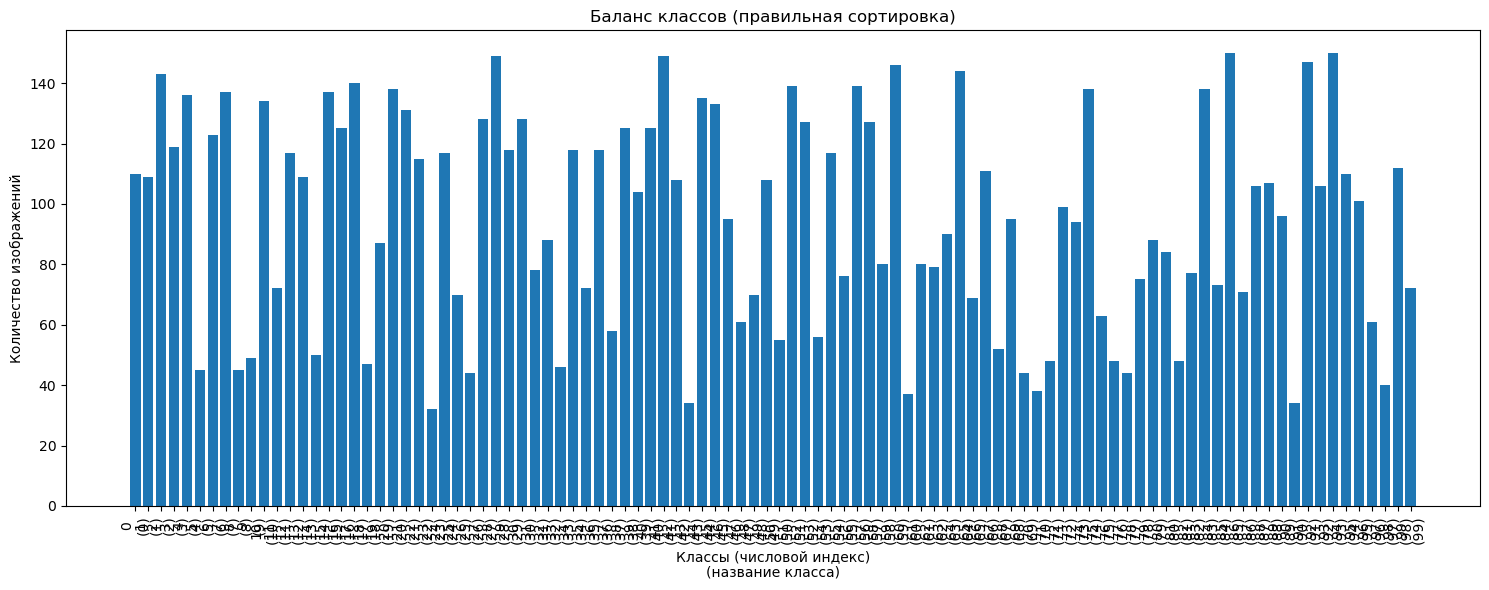

In [4]:
# Получаем классы и их названия
class_names = train_loader.dataset.classes  # ['0', '1', '10', '11', '12', ..., '2', ...]

# Преобразуем названия в числа для правильной сортировки
class_indices = [int(name) for name in class_names]
sorted_indices = np.argsort(class_indices)  # индексы для правильного порядка

# Считаем количество изображений для каждого класса (в правильном порядке)
class_counts = [0] * len(class_names)
for _, label in train_loader.dataset:
    class_counts[label] += 1

# Упорядочиваем данные
sorted_class_names = [class_names[i] for i in sorted_indices]
sorted_class_counts = [class_counts[i] for i in sorted_indices]
sorted_numeric_indices = [class_indices[i] for i in sorted_indices]  # числа 0,1,2,3,...

# Выводим статистику
print("Распределение классов (правильный порядок):")
for num_idx, class_idx in enumerate(sorted_indices):
    print(f"Класс {class_idx} ({class_names[class_idx]}): {class_counts[class_idx]} изображений")

# Визуализация
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(sorted_class_names)), sorted_class_counts)

# Подписи в формате "число\n(название)"
plt.xticks(range(len(sorted_class_names)), 
           [f"{num}\n({name})" for num, name in zip(sorted_numeric_indices, sorted_class_names)],
           rotation=90)
plt.xlabel("Классы (числовой индекс)\n(название класса)")
plt.ylabel("Количество изображений")
plt.title("Баланс классов (правильная сортировка)")
plt.tight_layout()
plt.show()

Минимум: 32
Максимум: 150
Соотношение max/min: 4.7 раз
Среднее: 95.1
Медиана: 100.0
Стандартное отклонение: 35.3 (37% от среднего)


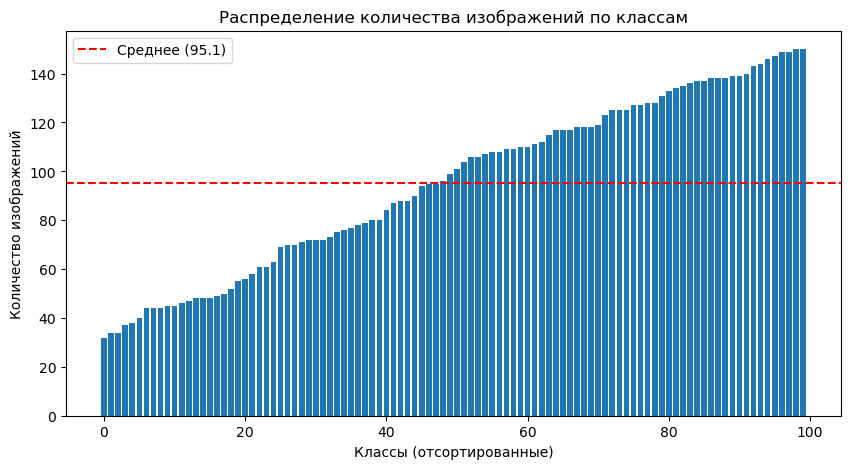

In [5]:
# Основные метрики
min_count = min(class_counts)
max_count = max(class_counts)
mean_count = np.mean(class_counts)
median_count = np.median(class_counts)
std_dev = np.std(class_counts)

print(f"Минимум: {min_count}")
print(f"Максимум: {max_count}")
print(f"Соотношение max/min: {max_count/min_count:.1f} раз")
print(f"Среднее: {mean_count:.1f}")
print(f"Медиана: {median_count}")
print(f"Стандартное отклонение: {std_dev:.1f} ({std_dev/mean_count*100:.0f}% от среднего)")

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), sorted(class_counts))
plt.axhline(mean_count, color='r', linestyle='--', label=f'Среднее ({mean_count:.1f})')
plt.xlabel("Классы (отсортированные)")
plt.ylabel("Количество изображений")
plt.title("Распределение количества изображений по классам")
plt.legend()
plt.show()

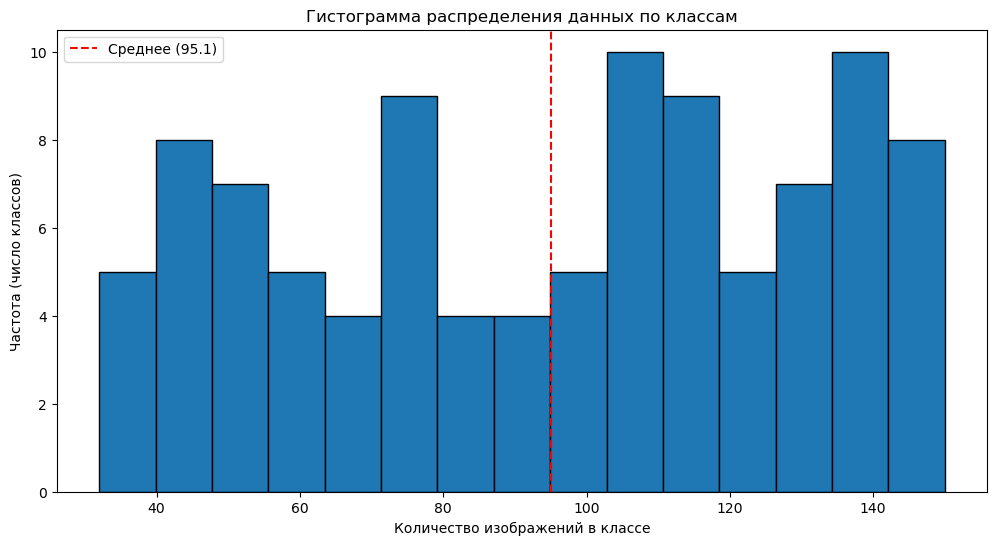

In [6]:
plt.figure(figsize=(12,6))
plt.hist(class_counts, bins=15, edgecolor='black')
plt.axvline(95.1, color='red', linestyle='--', label=f'Среднее (95.1)')
plt.xlabel('Количество изображений в классе')
plt.ylabel('Частота (число классов)')
plt.title('Гистограмма распределения данных по классам')
plt.legend()
plt.show()

from torchvision.utils import make_grid

def show_images(train_loader, class_idx, class_names, num_samples=5):
    # Получаем индексы всех изображений данного класса
    indices = [i for i, (_, label) in enumerate(train_loader) if label == class_idx]
    
    # Выбираем случайные примеры (без повторений, если возможно)
    selected_indices = np.random.choice(indices, min(num_samples, len(indices)), replace=False)
    
    # Загружаем изображения
    images = [train_loader[i][0] for i in selected_indices]
    
    # Создаём сетку изображений
    grid = make_grid(images, nrow=num_samples, normalize=True, padding=2)
    
    # Отображаем
    plt.figure(figsize=(15, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Класс {class_idx} ({class_names[class_idx]}): {len(indices)} примеров")
    plt.axis('off')
    plt.show()

# Получаем названия классов
class_names = train_loader.dataset.classes

# Создаём список уникальных классов, присутствующих в данных
unique_classes = sorted(set(train_loader.dataset.targets))

# Для каждого класса показываем примеры
for class_idx in unique_classes:
    show_images(train_loader.dataset, class_idx, class_names)

In [10]:
train_transform = A.Compose([
    A.Resize(224, 224),  # Все изображения одного размера
    A.HorizontalFlip(p=0.5),  # Отражение по горизонтали (50% chance)
    A.Rotate(limit=30),  # Поворот на ±30 градусов
    A.RandomBrightnessContrast(p=0.2),  # Случайная яркость/контраст
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
    ToTensorV2(),  # Конвертация в тензор
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])